In [1]:
import sys
sys.path.append('/home/punygod_admin/SoundSense/soundsense')

In [2]:
import torch
from sklearn.manifold import TSNE
from torchvision.models.feature_extraction import create_feature_extractor
import matplotlib.pyplot as plt
from matplotlib import patches
import torch.nn as nn
from models.baselines.mulsa.inference import MULSAInference
from models.imi_datasets import ImitationEpisode
from models.baselines.mulsa.src.models.encoders import (
    make_vision_encoder,
    make_audio_encoder,
)
from models.baselines.mulsa.src.models.imi_models import Actor
from models.baselines.mulsa.src.engines.engine import ImiEngine
import numpy as np
import os
import yaml
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-25 19:33:10.760955: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [40]:
def attention_across_runs(attention_weights_all):
    num_heads = attention_weights_all.shape[1]
    matrix_shape = attention_weights_all.shape[2:4]
    num_runs = 200
    start = 0
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))  # Adjusted for 2 rows and 4 columns
    axes = axes.flatten()
    for head_index, ax in enumerate(axes):
        # Plot each element in the matrix
        for i in range(matrix_shape[0]):
            for j in range(matrix_shape[1]):
                # Extract the weights for this element across all runs
                weights = attention_weights_all[start:start+num_runs, head_index, i, j]
                ax.plot(range(1, num_runs + 1), weights, marker='o', label=f'Element ({i+1},{j+1})')

        ax.set_title(f'Head {head_index+1}')
        ax.set_xlabel('Model Run')
        ax.set_ylabel('Attention Weight')
        ax.set_xticks(range(1, num_runs + 1))
        ax.set_xticklabels(range(1, num_runs + 1), rotation='vertical')
        ax.legend()
    plt.title('Attention Weights Across Runs')
    plt.tight_layout()
    plt.show()


#   fig, axes = plt.subplots(nrows=1, ncols=num_heads, figsize=(20, 5))  # One row of plots

#   for head_index, ax in enumerate(axes):
#       # Plot each element in the matrix
#       for i in range(matrix_shape[0]):
#           for j in range(matrix_shape[1]):
#               # Extract the weights for this element across all runs
#               weights = attention_weights_all[:, head_index, i, j]
#               ax.plot(range(1, num_runs + 1), weights, marker='o', label=f'Element ({i+1},{j+1})')
      
#       ax.set_title(f'Head {head_index+1}')
#       ax.set_xlabel('Model Run')
#       ax.set_ylabel('Attention Weight')
#       ax.set_xticks(range(1, num_runs + 1))
#       ax.legend()
  



In [41]:
def attention_plot(config, model, seq_len = 0, name = 'vg_simple_seqlen_1_mha_spec', device='cuda',):

    np.random.seed(0)
    run_ids = os.listdir('/home/punygod_admin/SoundSense/soundsense/data/mulsa/sorting')
    np.random.permutation(run_ids)
    train_val_split = 0.8
    split = int(train_val_split*len(run_ids))
    train_episodes = run_ids[:split]
    val_episodes = run_ids[split:]

    print("Train episodes: ", len(train_episodes))
    print("Val episodes: ", len(val_episodes))
    val_set = torch.utils.data.ConcatDataset(
        [
            ImitationEpisode(config, run_id, train=False)
            for run_id in val_episodes
        ]
    )

    val_loader = DataLoader(val_set, num_workers=config["num_workers"], shuffle=False,batch_size=1)

    weights_list = []
    targets_list = []
    indices = []
    
    for i, (img, target) in enumerate(val_loader):
        img[0] = img[0].squeeze(0)
        img[0] = img[0].permute(0, 2, 3, 1)
        # print(img[1].squeeze(0).shape)
        inp = {"video": np.array(img[0]), "audio": img[1].squeeze(0).to(device)}  
        if i > 999:
            break
        with torch.no_grad():
            output  = model(inp)
            weights = model.get_weights()
        weights_list.append(weights.cpu().numpy())
        if seq_len:
            targets_list.append(target[0][0][-1,].unsqueeze(0))
        else:
            targets_list.append(target[0][0])
        indices.append(i)
        
    weights = np.squeeze(np.array(weights_list), axis=1)

    ## save the weights in a txt file
    print(weights.shape)
    np.savetxt('weights_' + name + '_.txt', weights.reshape(-1, 8))

    ## plot across runs
    attention_across_runs(weights)

    attention_weights = weights[0]
    num_heads, output_seq_len, input_seq_len = attention_weights.shape
    print(attention_weights.shape)

    # fig, axes = plt.subplots(nrows=num_heads, ncols=1, figsize=(10, 4*num_heads))
    
    # for i, ax in enumerate(axes):
    #     # print(i)
    #     ax.set_title(f'Attention Head {i+1}')
    #     ax.imshow(attention_weights[i], cmap='viridis', interpolation='nearest', aspect='auto')
    #     ax.set_xlabel('Input Sequence')
    #     ax.set_ylabel('Output Sequence')
    #     ax.set_xticks(np.arange(input_seq_len))
    #     ax.set_yticks(np.arange(output_seq_len))
    #     ax.grid(color='gray', linestyle='-', linewidth=0.5)
    #     ax.xaxis.set_tick_params(rotation=45)
    #     ax.colorbar = ax.figure.colorbar(ax.imshow(attention_weights[i]), ax=ax)
    
    # plt.tight_layout()
    # plt.show()
    
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))  # Adjusted grid size and figure size

    # Flatten the axes array for easier iteration if it's 2D
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < num_heads:
            ax.set_title(f'Attention Head {i+1}')
            im = ax.imshow(attention_weights[i], cmap='viridis', interpolation='nearest', aspect='auto')
            ax.set_xlabel('Input Sequence')
            ax.set_ylabel('Output Sequence')
            ax.set_xticks(np.arange(input_seq_len))
            ax.set_yticks(np.arange(output_seq_len))
            ax.grid(color='gray', linestyle='-', linewidth=0.5)
            ax.xaxis.set_tick_params(rotation=45)

            # Colorbar adjustment for each subplot
            fig.colorbar(im, ax=ax)
        else:
            ax.axis('off')  # Turn off axis for any subplot not being used (if num_heads < 8)
    plt.title('Attention Weights for Each Head for a Single Input Sequence') 
    plt.tight_layout()
    plt.show()




### sorting_imi_vg_simple_seqlen_1_mha_spec


Using GPU
Creating simple decoder
Total parameters: 36.105352 Million
NUM STACK:  6
Train episodes:  79
Val episodes:  20


/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(1000, 8, 1, 1)


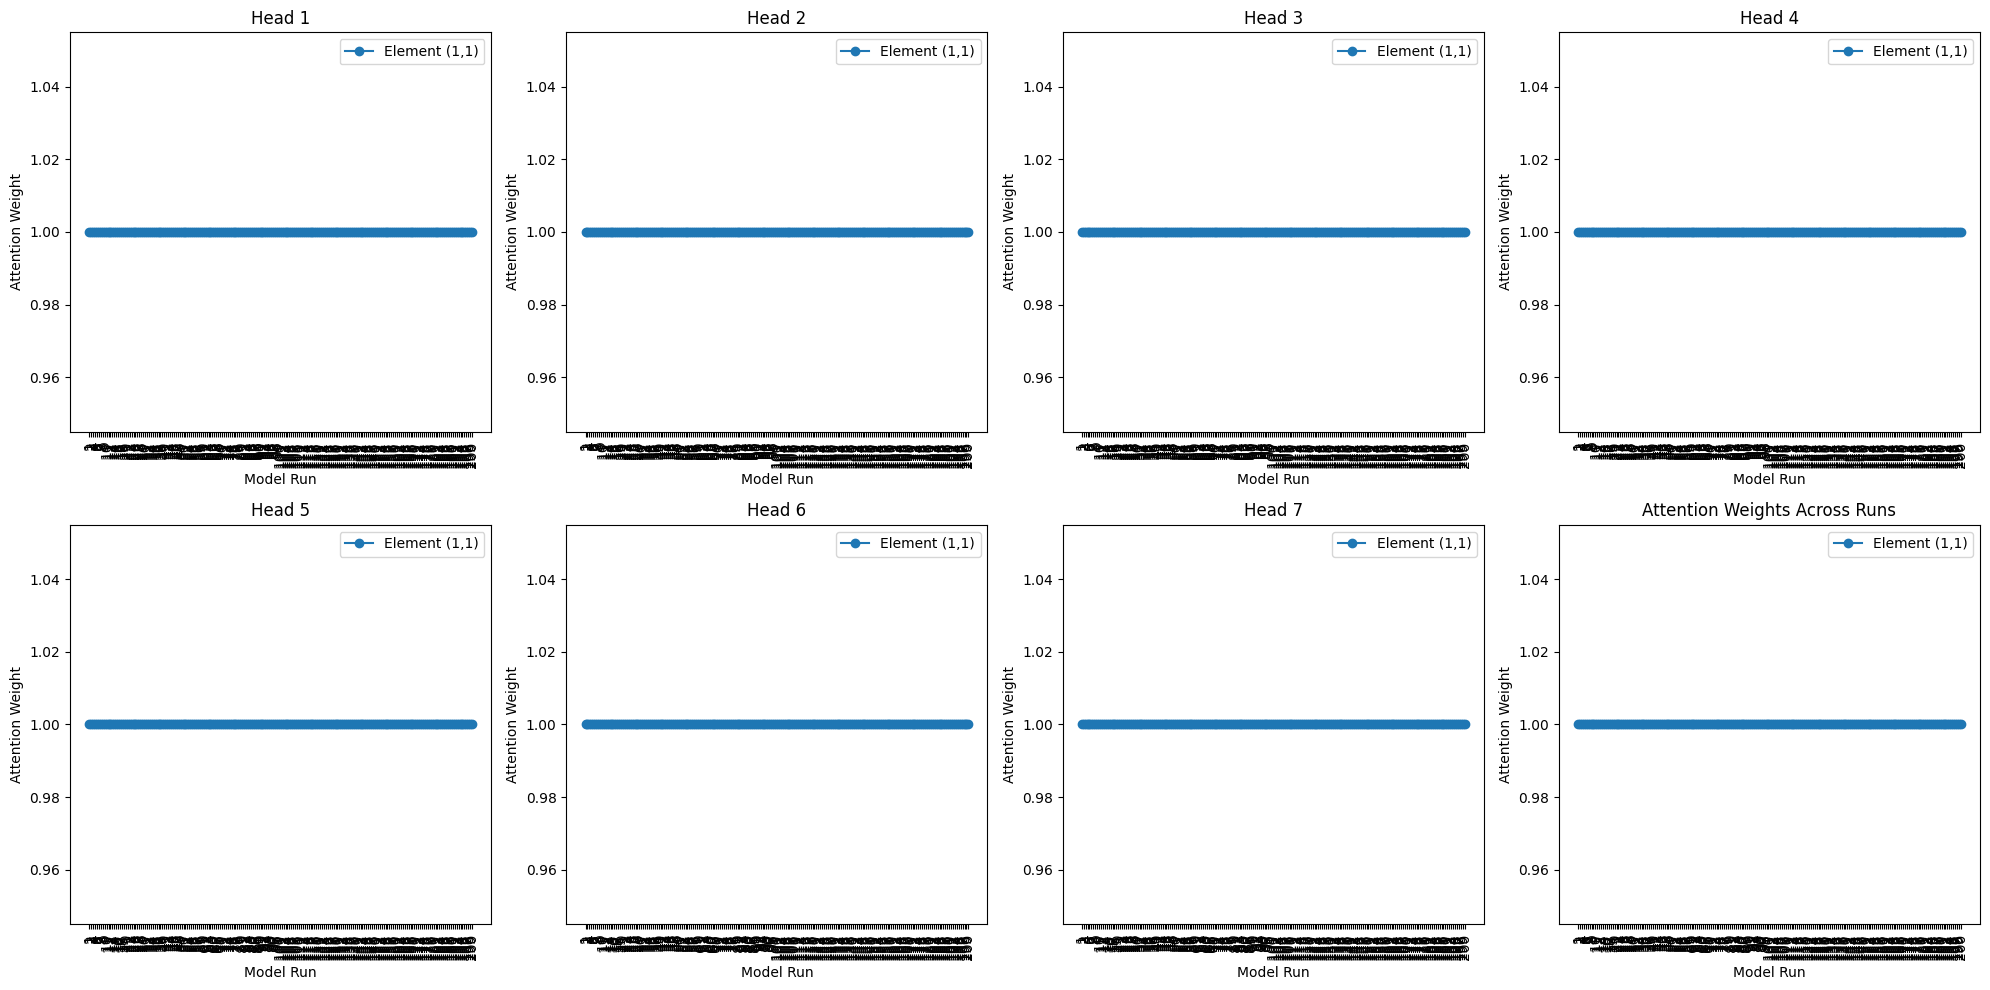

(8, 1, 1)


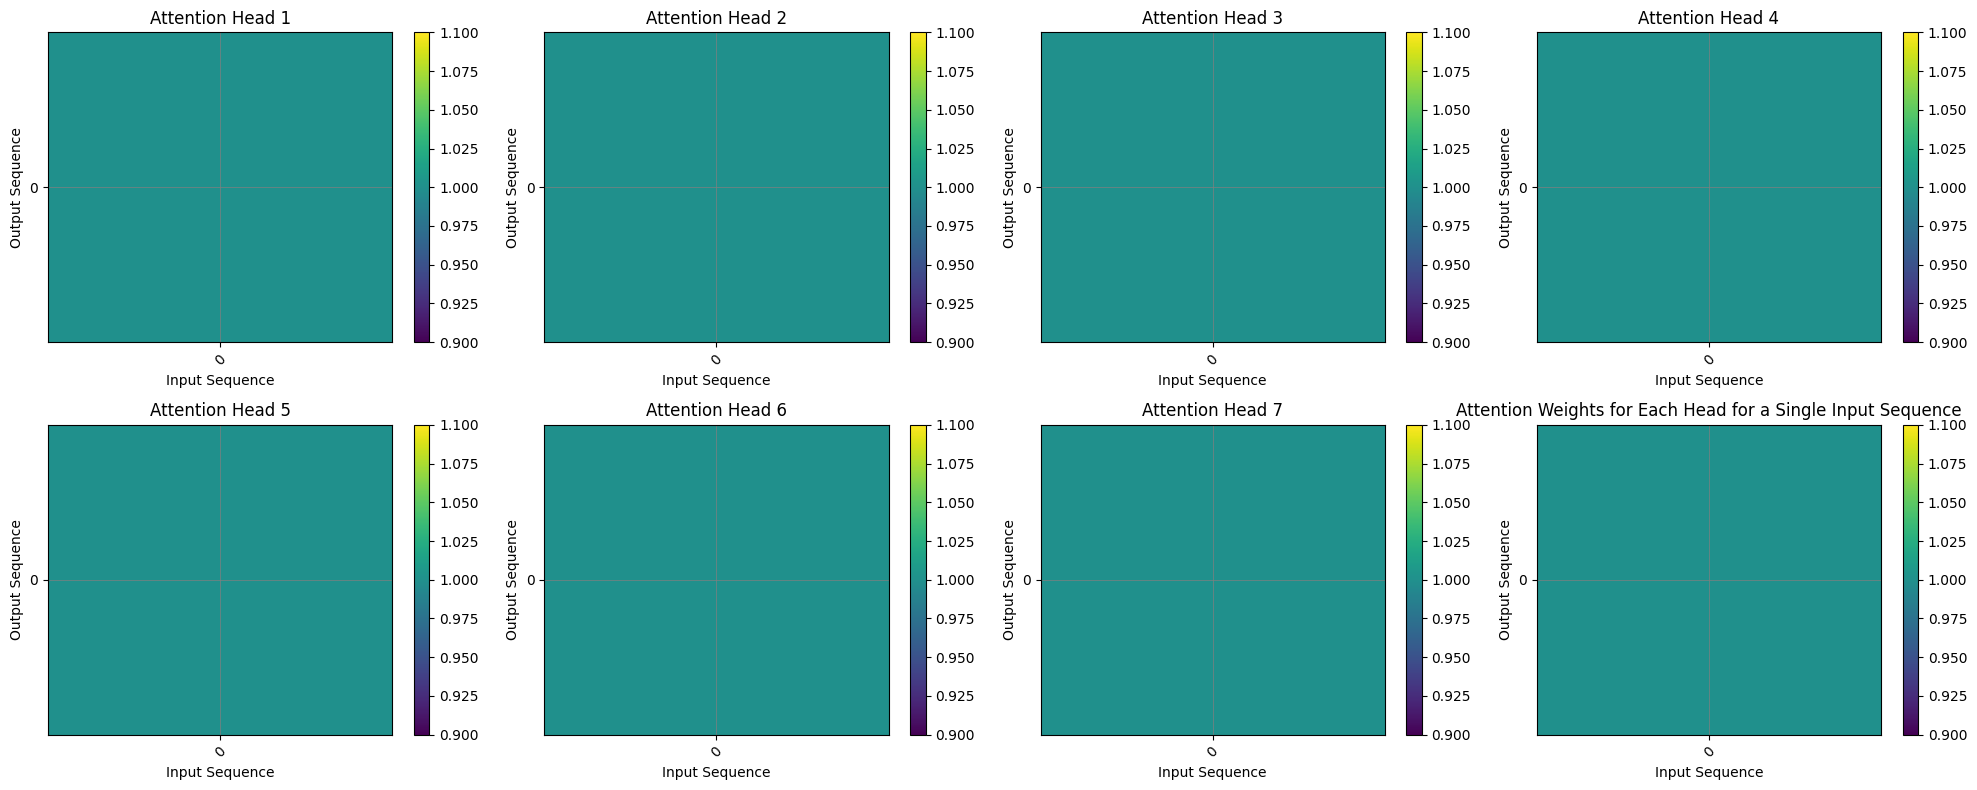

In [42]:
model_path = "/home/punygod_admin/SoundSense/soundsense/models/baselines/mulsa/lightning_logs/sorting_imi_vg_simple_seqlen_1_mha_spec04-22-04:18:40/last.ckpt"
config_path = '/home/punygod_admin/SoundSense/soundsense/models/baselines/mulsa/lightning_logs/sorting_imi_vg_simple_seqlen_1_mha_spec04-22-04:18:40/hparams.yaml'

with open(config_path) as f:
        config = yaml.load(f, Loader=yaml.FullLoader)

model = MULSAInference(config_path)

# Load the model from the checkpoint
model.load_state_dict(
        torch.load(
            model_path,
            map_location=torch.device("cpu"),
        )['state_dict']
    )
# model = model.load_from_checkpoint(model_path)

# Then, move the model to CUDA device
model = model
model.eval().cuda()

attention_plot(config, model)

### sorting_imi_vg_lstm_seqlen_3_mha_spec

Using GPU
Creating LSTM decoder
Total parameters: 36.534024 Million
NUM STACK:  6
Train episodes:  79
Val episodes:  20


/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(1000, 8, 1, 1)


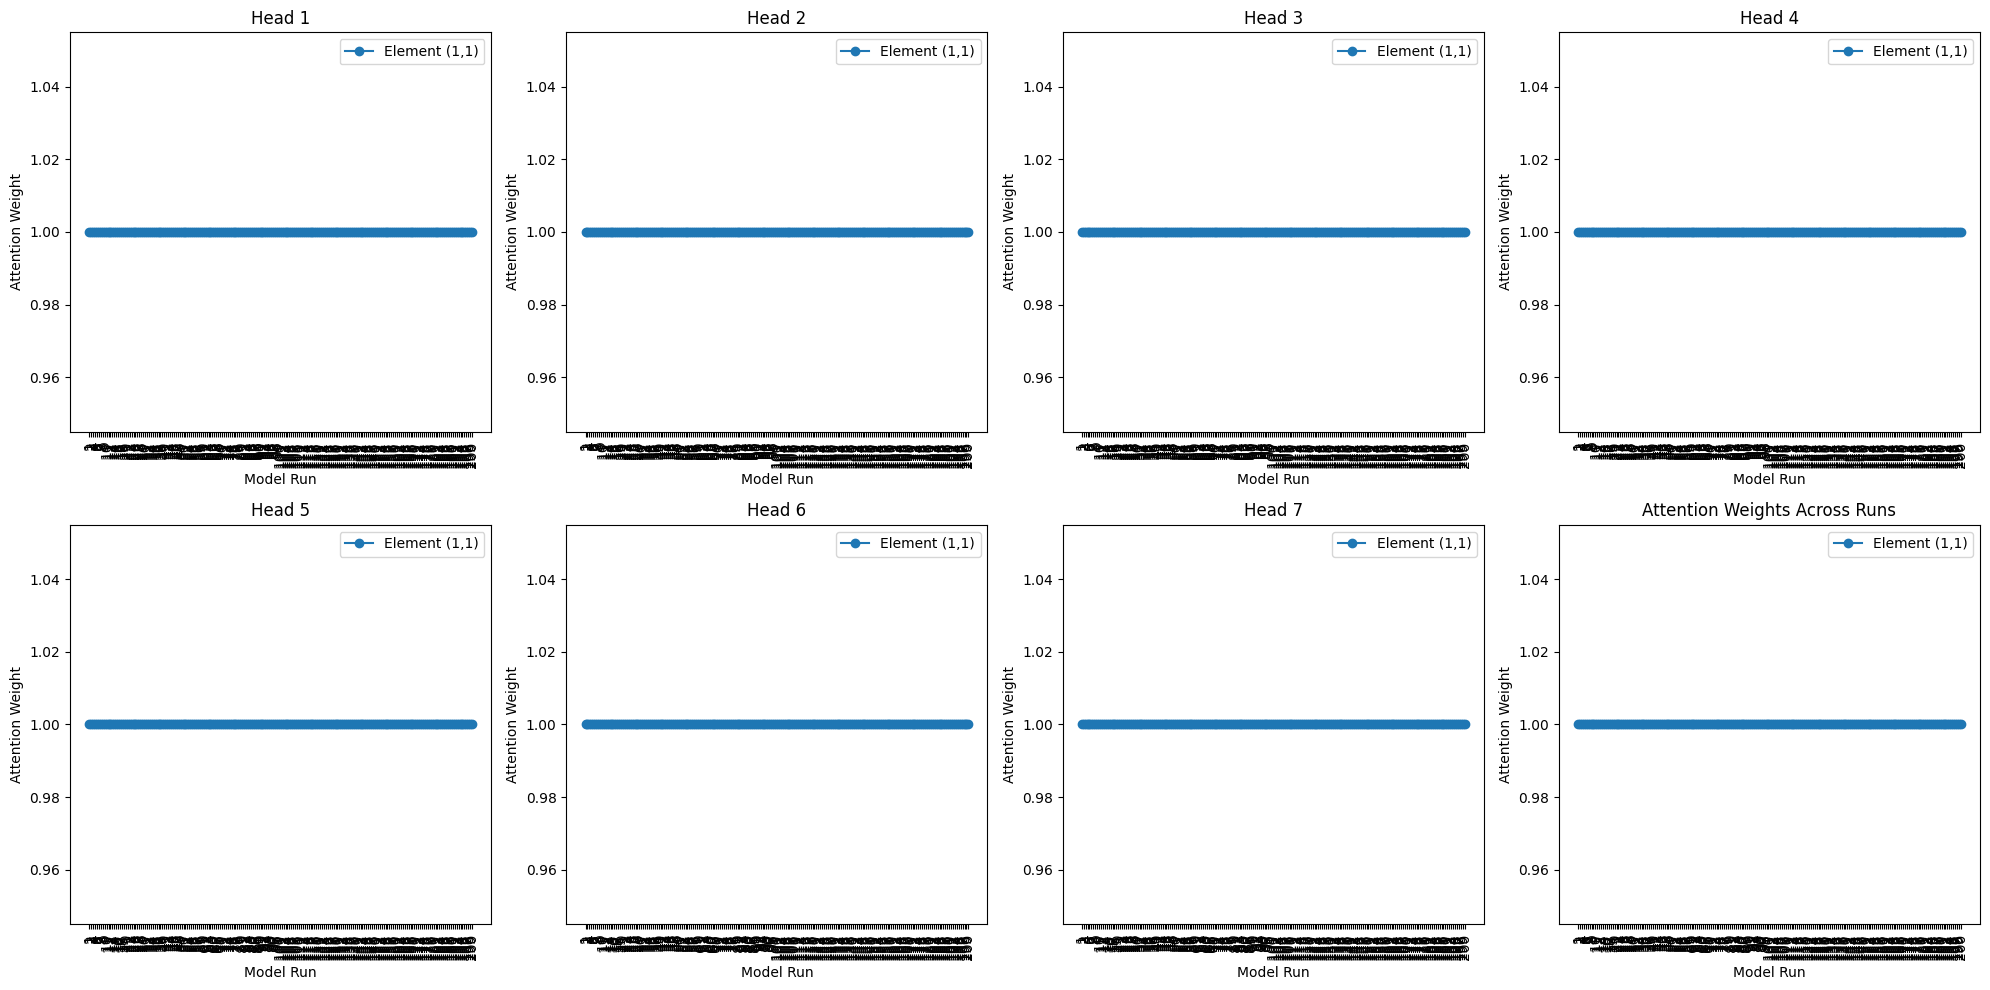

(8, 1, 1)


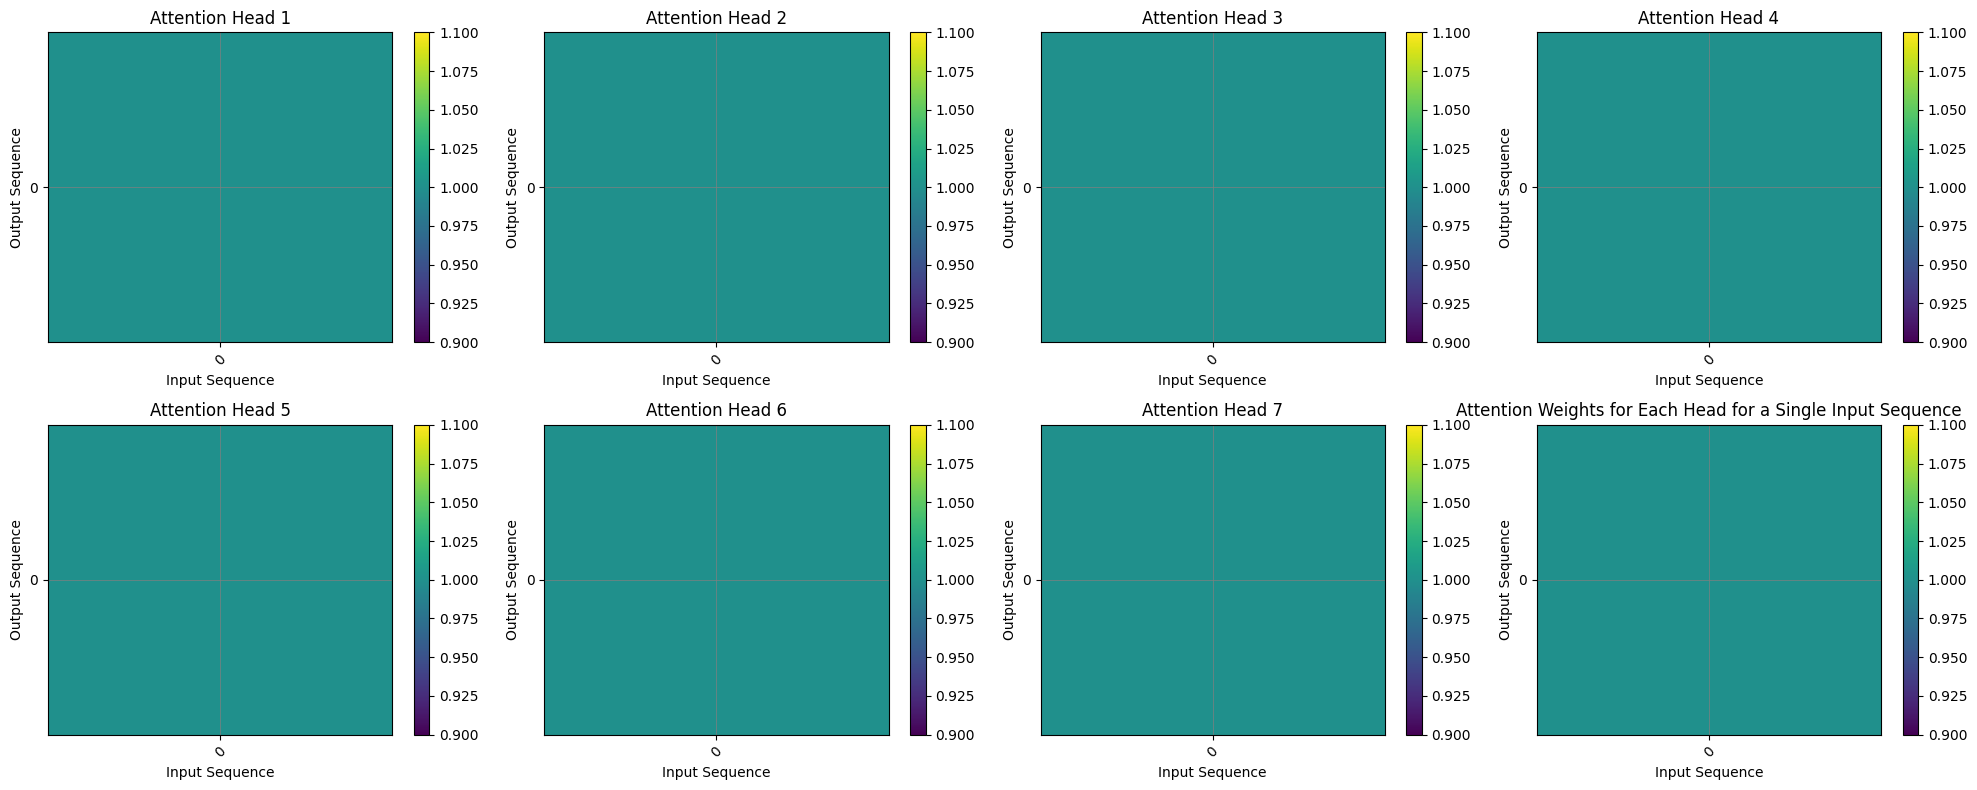

In [43]:
model_path = "/home/punygod_admin/SoundSense/soundsense/models/baselines/mulsa/lightning_logs/sorting_imi_vg_lstm_seqlen_3_mha_spec04-21-21:13:43/last.ckpt"
config_path = '/home/punygod_admin/SoundSense/soundsense/models/baselines/mulsa/lightning_logs/sorting_imi_vg_lstm_seqlen_3_mha_spec04-21-21:13:43/hparams.yaml'
with open(config_path) as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
model = MULSAInference(config_path)

# Load the model from the checkpoint
model.load_state_dict(
        torch.load(
            model_path,
            map_location=torch.device("cpu"),
        )['state_dict']
    )
# model = model.load_from_checkpoint(model_path)

# Then, move the model to CUDA device
model = model.cuda()
model.eval()

attention_plot(config, model, 1, 'vg_lstm_seqlen_3_mha_spec')

### sorting_imi_vg_ag_simple_seqlen_1_mha_spec

Using GPU
Creating simple decoder
Total parameters: 38.464648 Million
NUM STACK:  6
Train episodes:  79
Val episodes:  20
Loading audio for ng/87
Loading audio for ng/94
Loading audio for ng/42
Loading audio for ng/98
Loading audio for ng/86
Loading audio for ng/80
Loading audio for ng/48
Loading audio for ng/16
Loading audio for ing/4
Loading audio for ng/97
Loading audio for ng/71
Loading audio for ng/78
Loading audio for ng/17
Loading audio for ng/83
Loading audio for ing/7
Loading audio for ng/69
Loading audio for ng/19
Loading audio for ng/56
Loading audio for ing/9
Loading audio for ng/88


/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(1000, 8, 2, 2)


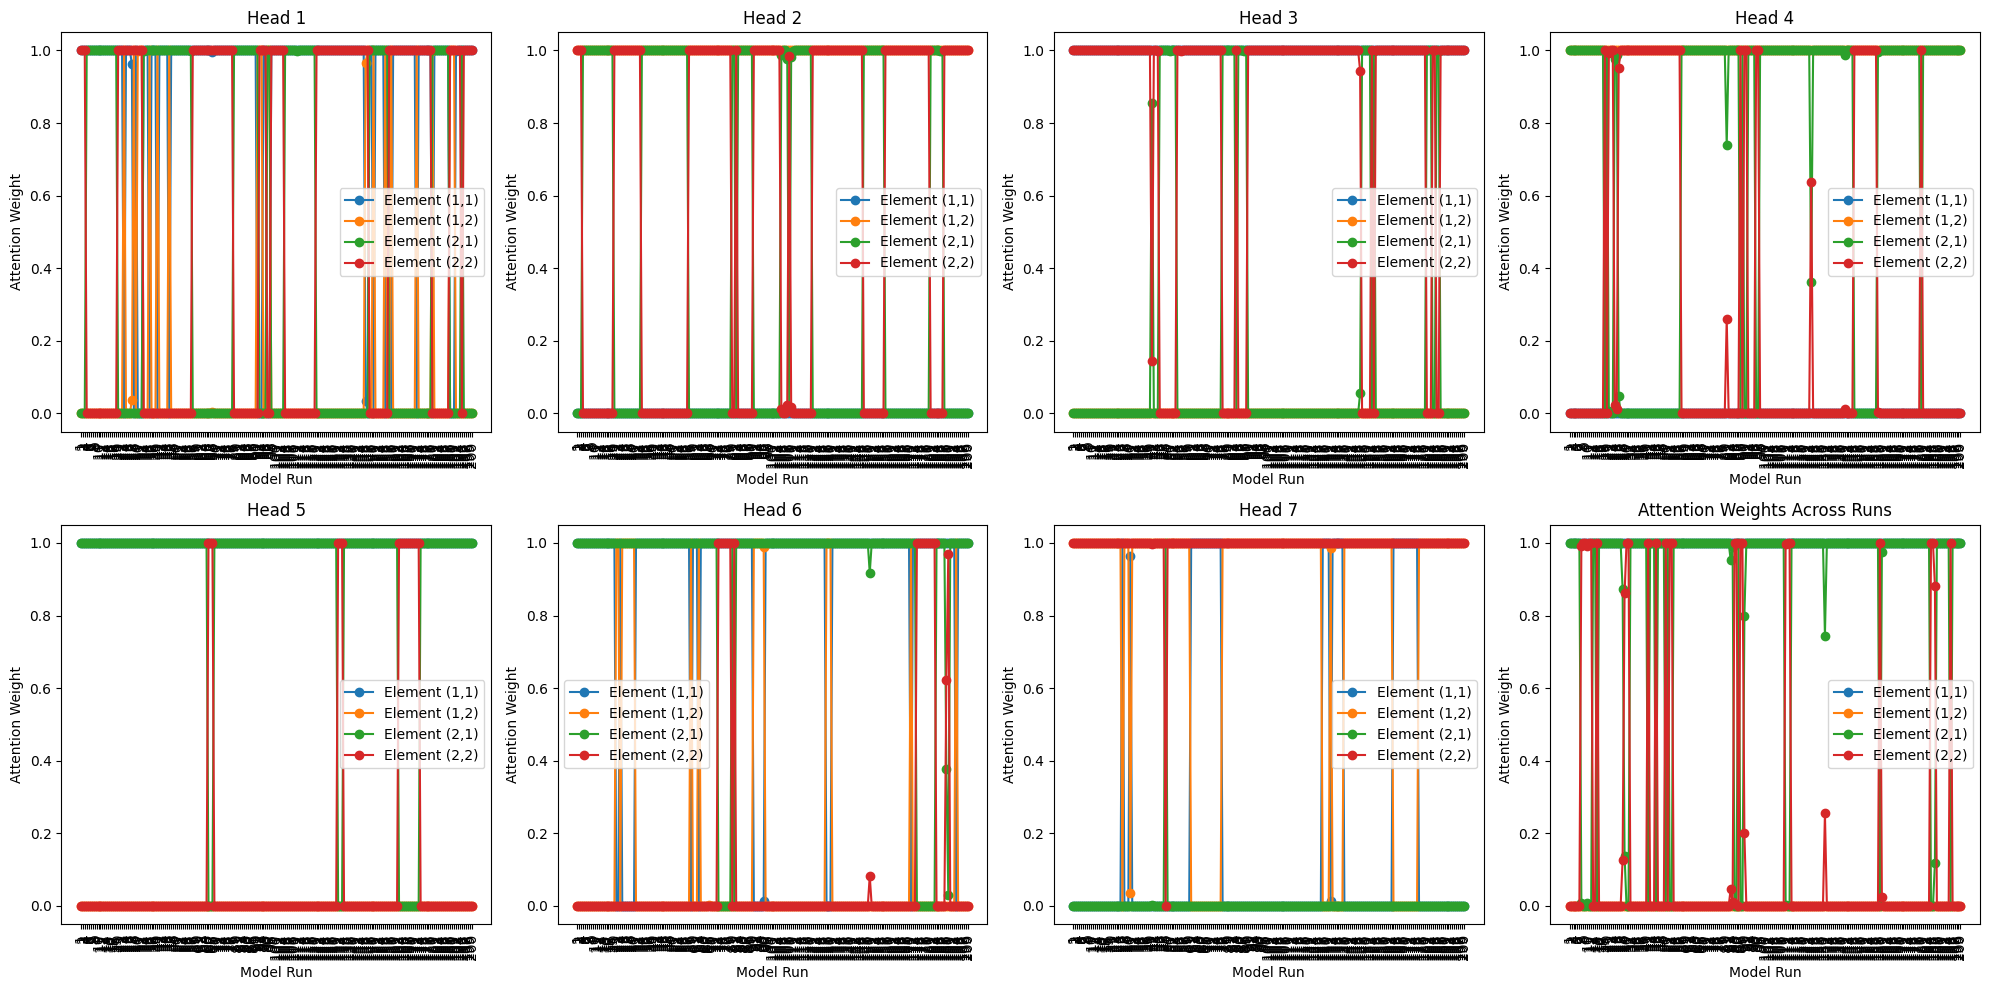

(8, 2, 2)


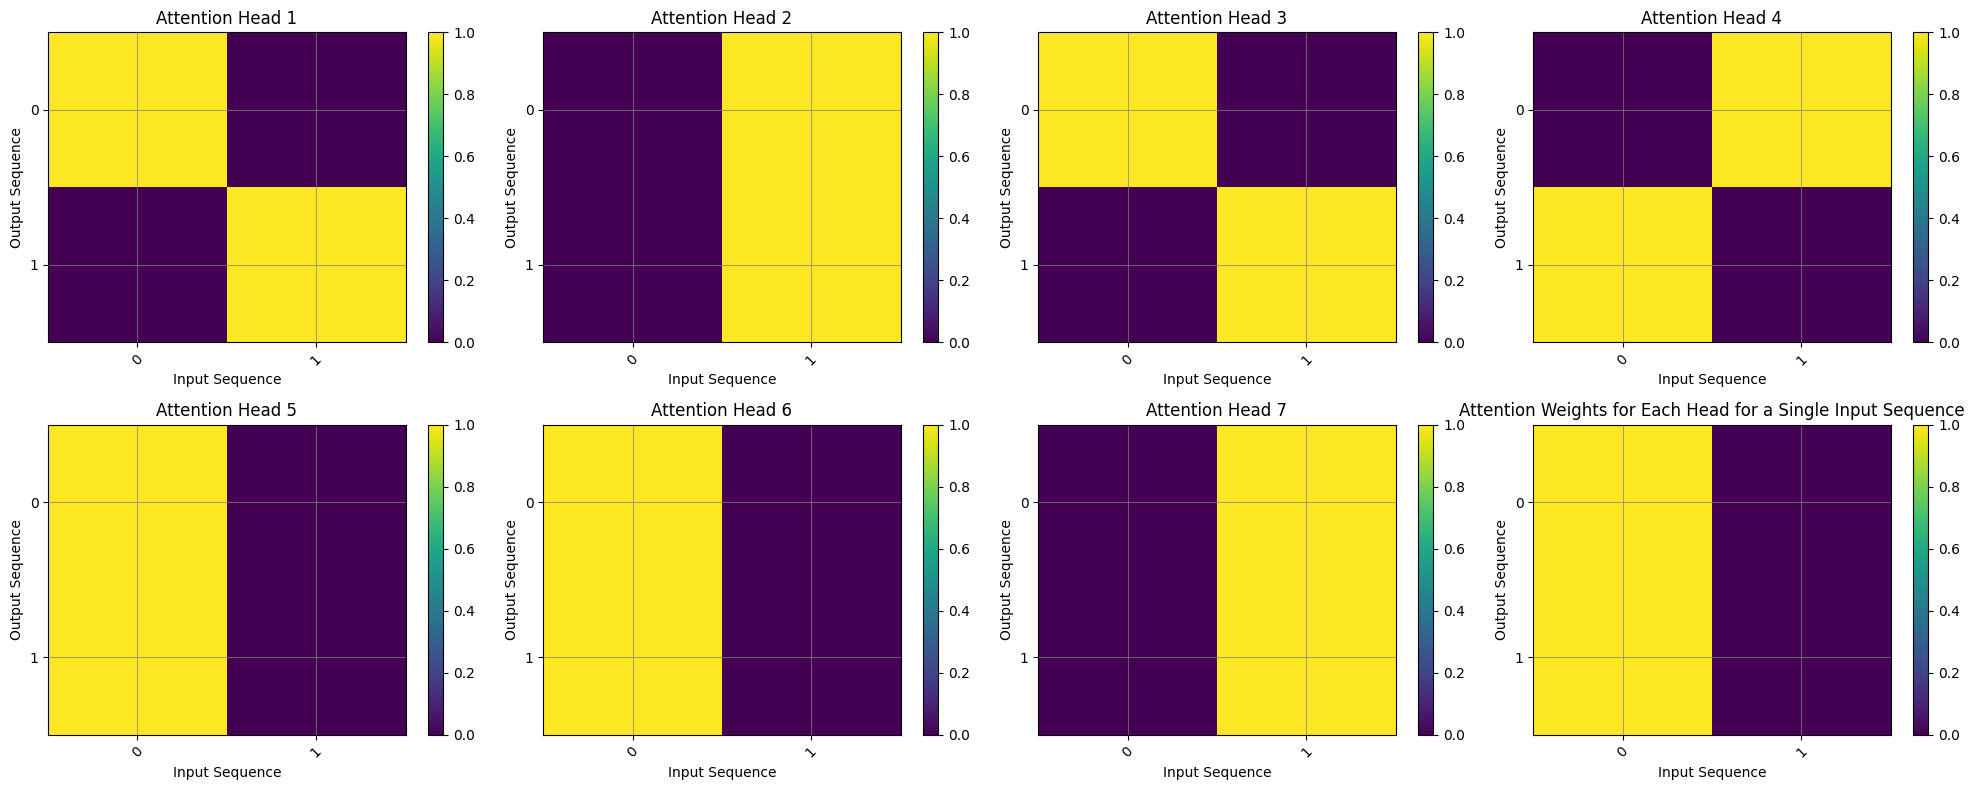

In [44]:
model_path = "/home/punygod_admin/SoundSense/soundsense/models/baselines/mulsa/lightning_logs/sorting_imi_vg_ag_simple_seqlen_1_mha_spec04-22-15:08:58/last.ckpt"
config_path = "/home/punygod_admin/SoundSense/soundsense/models/baselines/mulsa/lightning_logs/sorting_imi_vg_ag_simple_seqlen_1_mha_spec04-22-15:08:58/hparams.yaml"
with open(config_path) as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
model = MULSAInference(config_path)

# Load the model from the checkpoint
model.load_state_dict(
        torch.load(
            model_path,
            map_location=torch.device("cpu"),
        )['state_dict']
    )
# model = model.load_from_checkpoint(model_path)

# Then, move the model to CUDA device
model = model.cuda()
model.eval()

attention_plot(config, model,0, 'vg_ag_simple_seqlen_1_mha_spec')

### sorting_imi_vg_ag_lstm_seqlen_3_mha_spec

Using GPU
Creating LSTM decoder
Total parameters: 38.89332 Million
NUM STACK:  6
Train episodes:  79
Val episodes:  20
Loading audio for ng/87
Loading audio for ng/94
Loading audio for ng/42
Loading audio for ng/98
Loading audio for ng/86
Loading audio for ng/80
Loading audio for ng/48
Loading audio for ng/16
Loading audio for ing/4
Loading audio for ng/97
Loading audio for ng/71
Loading audio for ng/78
Loading audio for ng/17
Loading audio for ng/83
Loading audio for ing/7
Loading audio for ng/69
Loading audio for ng/19
Loading audio for ng/56
Loading audio for ing/9
Loading audio for ng/88


/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(1000, 8, 2, 2)


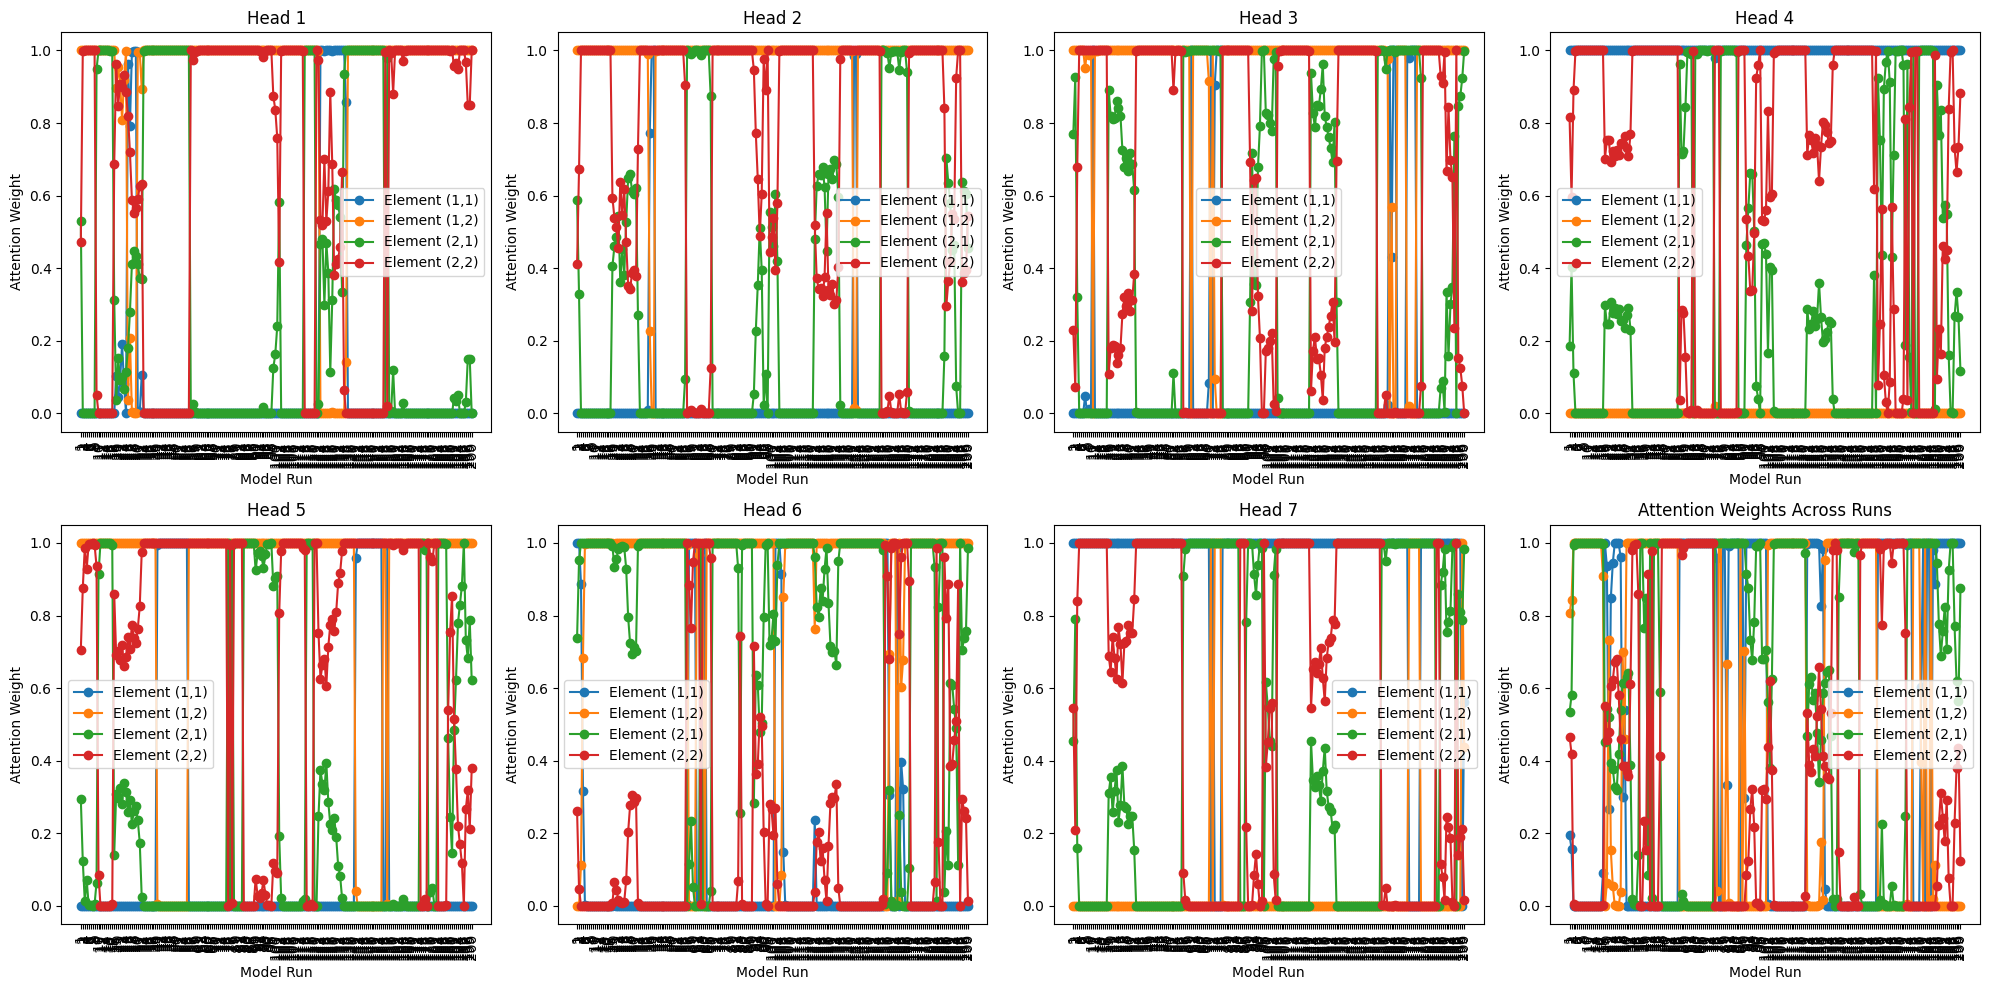

(8, 2, 2)


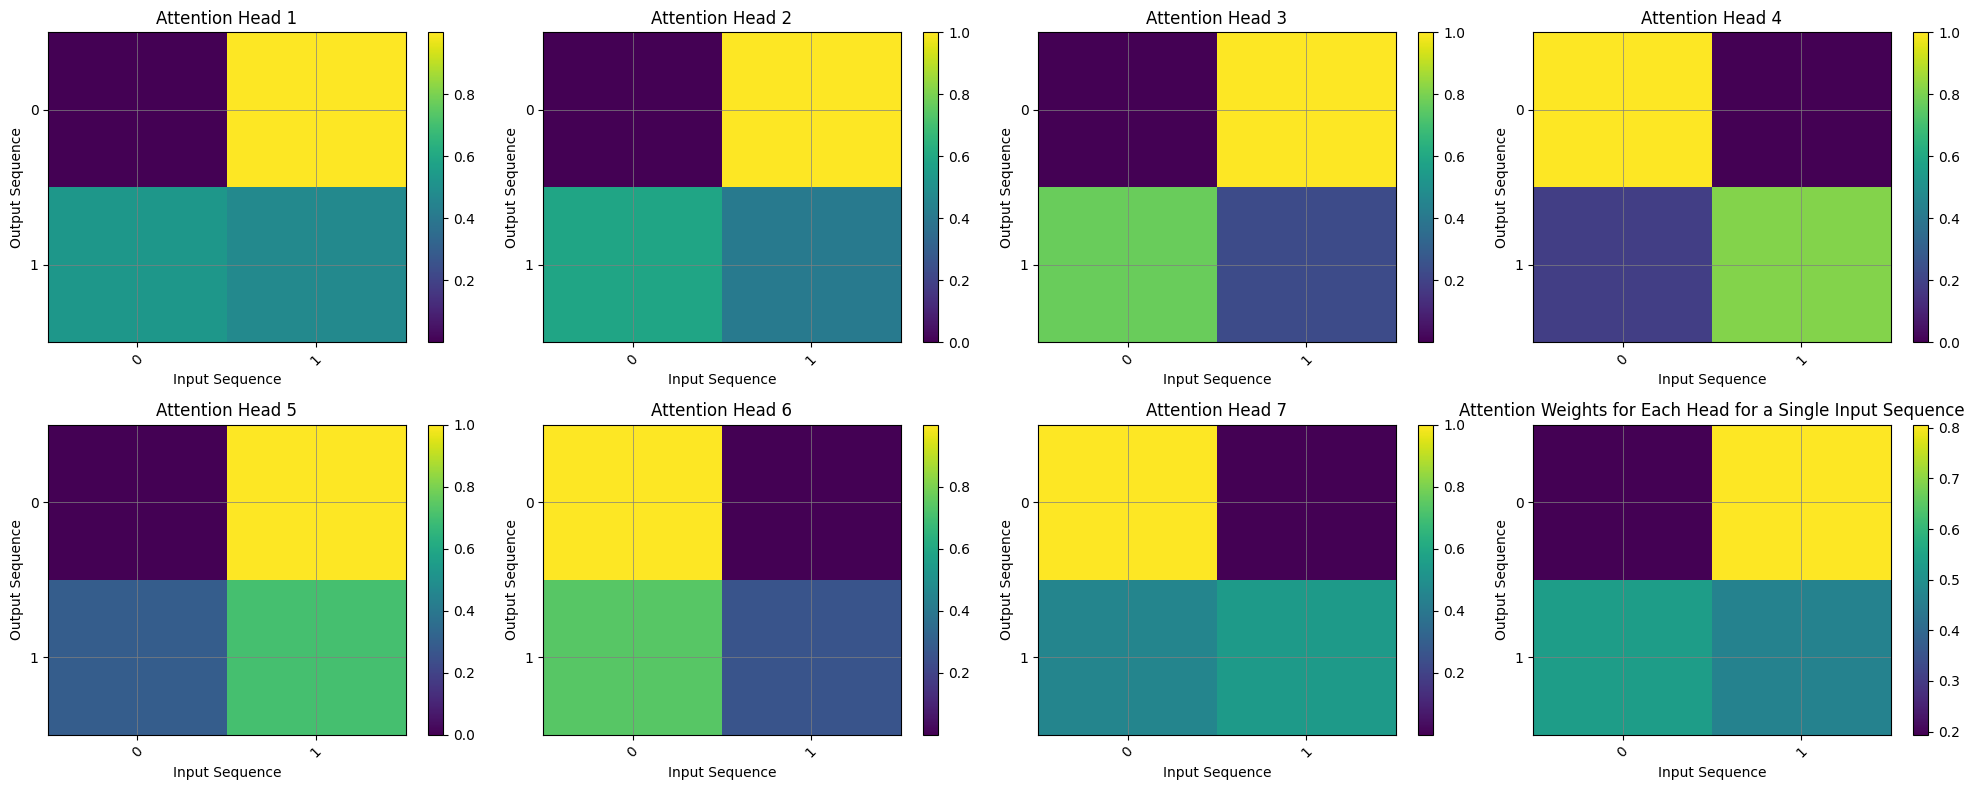

In [45]:
model_path = "/home/punygod_admin/SoundSense/soundsense/models/baselines/mulsa/lightning_logs/sorting_imi_vg_ag_lstm_seqlen_3_mha_spec04-22-19:26:28/last.ckpt"
config_path = "/home/punygod_admin/SoundSense/soundsense/models/baselines/mulsa/lightning_logs/sorting_imi_vg_ag_lstm_seqlen_3_mha_spec04-22-19:26:28/hparams.yaml"
with open(config_path) as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
model = MULSAInference(config_path)

# Load the model from the checkpoint
model.load_state_dict(
        torch.load(
            model_path,
            map_location=torch.device("cpu"),
        )['state_dict']
    )
# model = model.load_from_checkpoint(model_path)

# Then, move the model to CUDA device
model = model.cuda()
model.eval()

attention_plot(config, model, 1, 'vg_ag_lstm_seqlen_3_mha_spec')

### sorting_imi_vg_ag_lstm_seqlen_3_mha_spec_pretrained

Using GPU
Creating LSTM decoder
Total parameters: 38.89332 Million
NUM STACK:  6
Train episodes:  79
Val episodes:  20
Loading audio for ng/87
Loading audio for ng/94
Loading audio for ng/42
Loading audio for ng/98
Loading audio for ng/86
Loading audio for ng/80
Loading audio for ng/48
Loading audio for ng/16
Loading audio for ing/4
Loading audio for ng/97
Loading audio for ng/71
Loading audio for ng/78
Loading audio for ng/17
Loading audio for ng/83
Loading audio for ing/7
Loading audio for ng/69
Loading audio for ng/19
Loading audio for ng/56
Loading audio for ing/9
Loading audio for ng/88


/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(1000, 8, 2, 2)


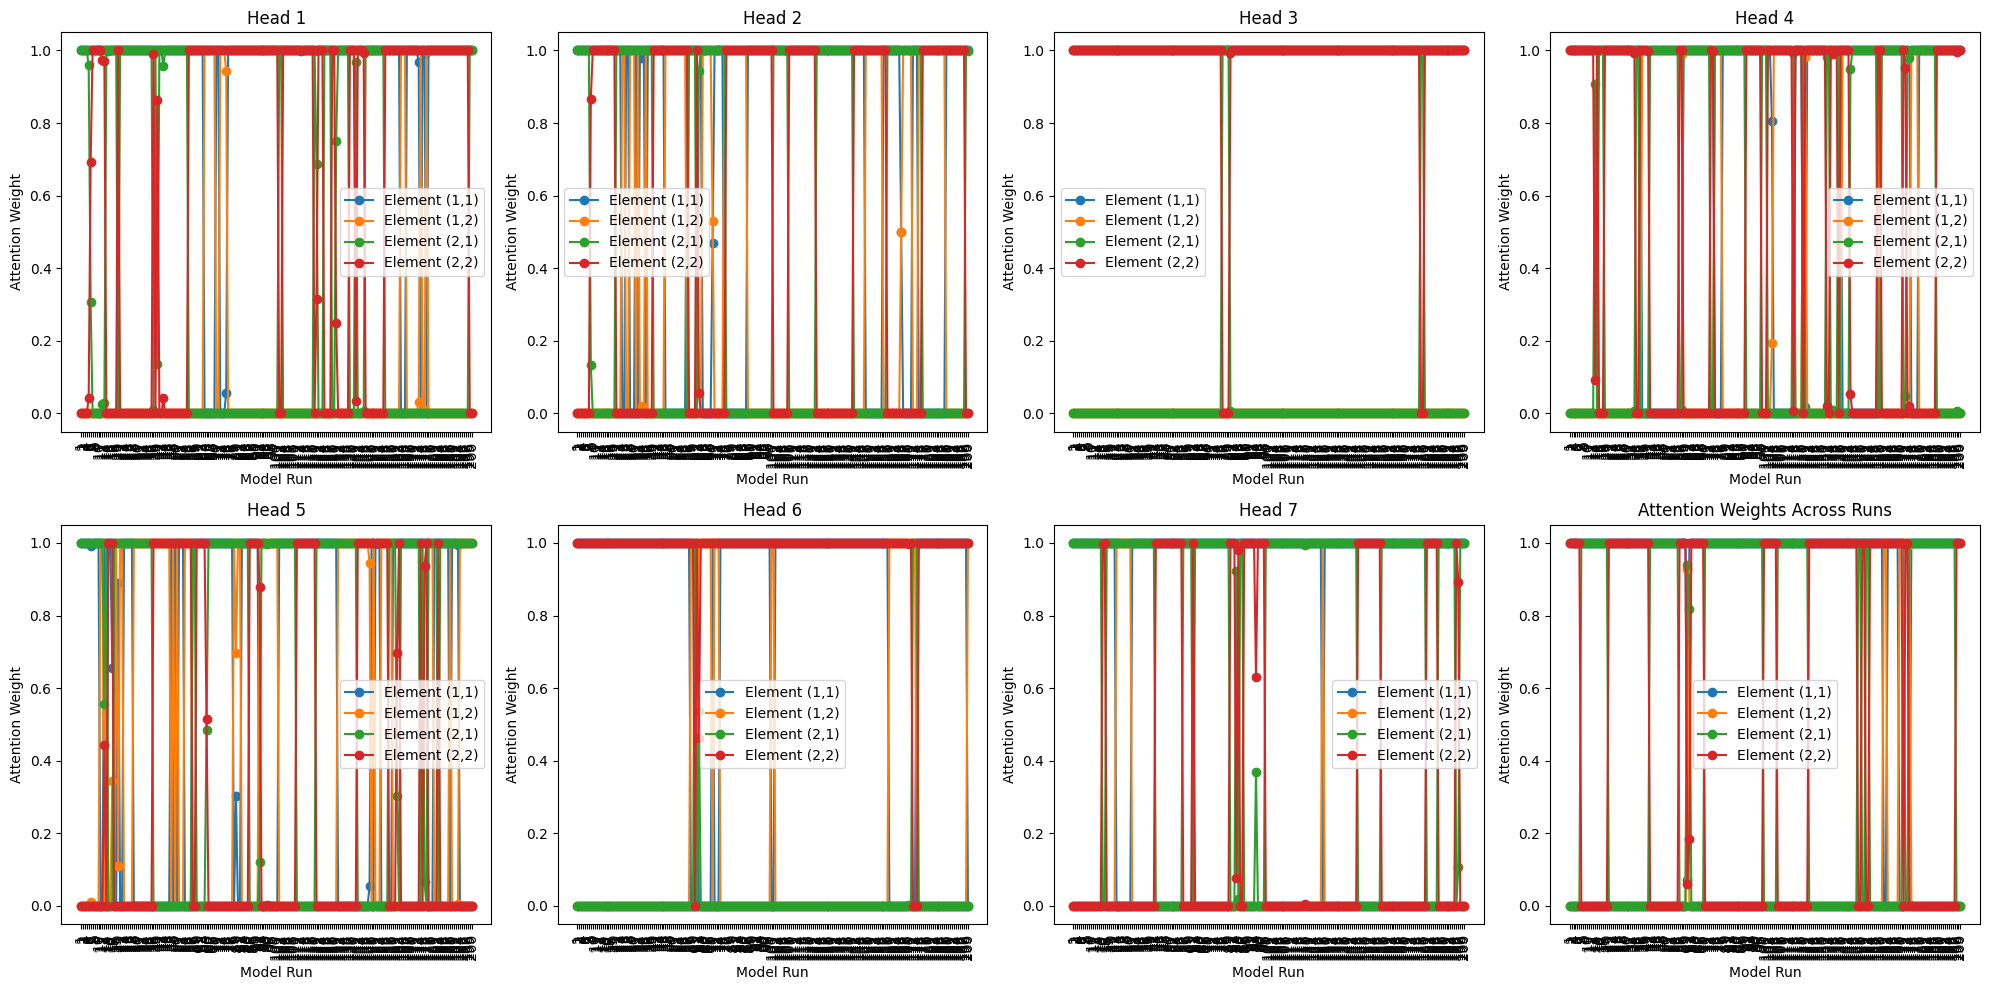

(8, 2, 2)


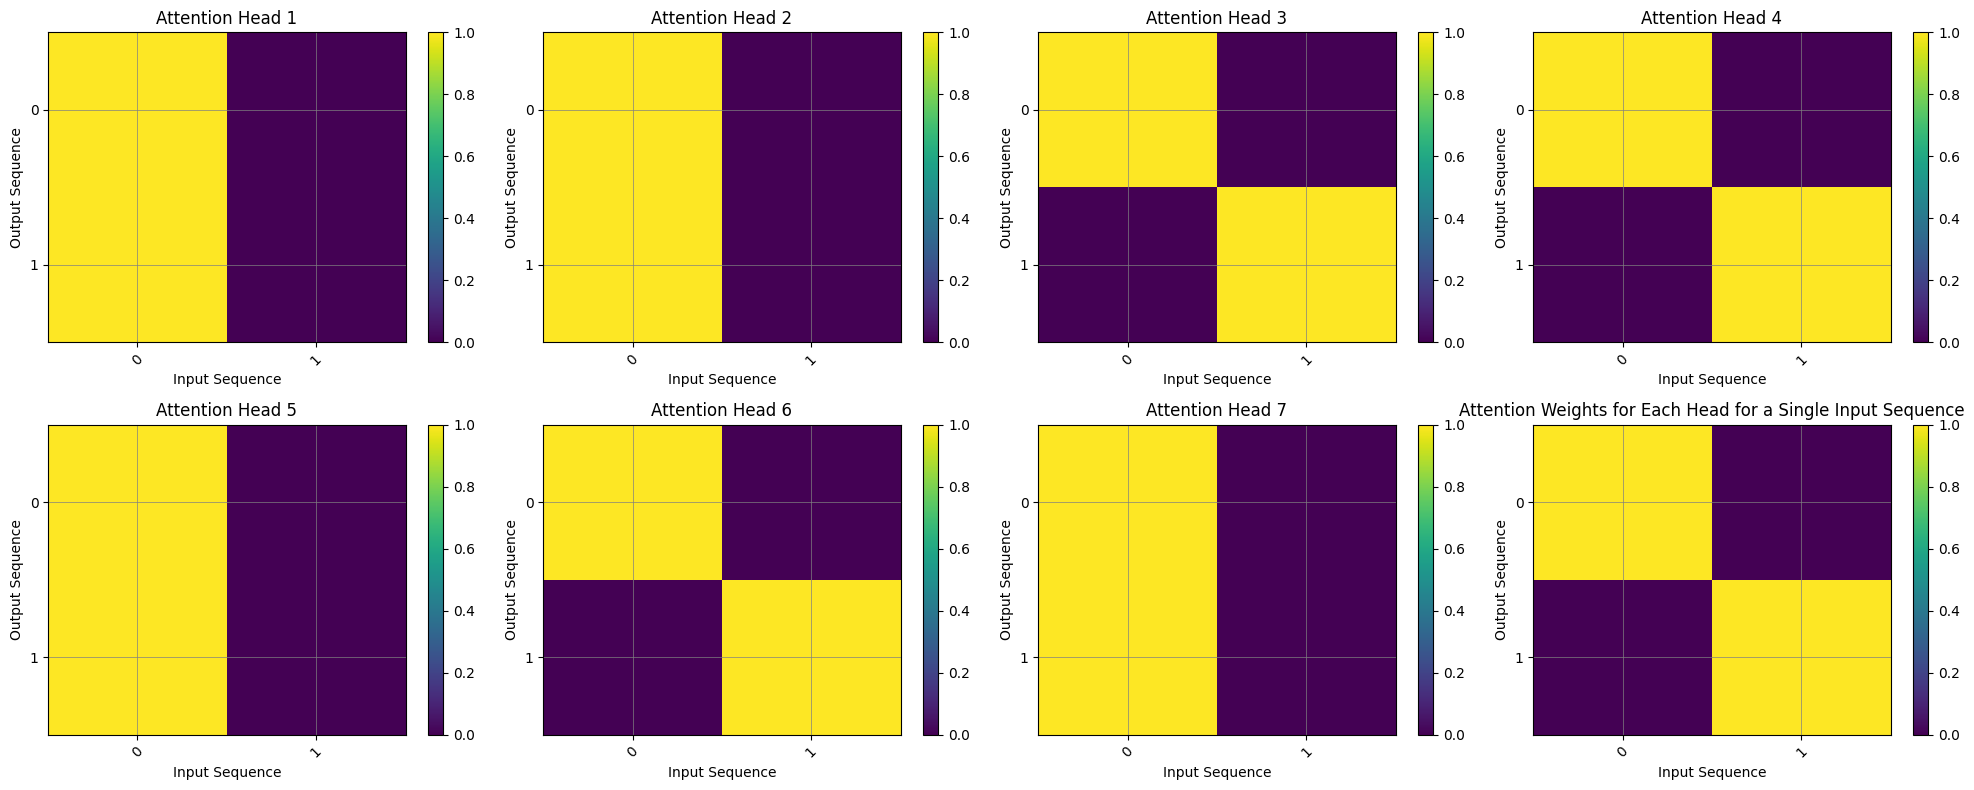

In [46]:
model_path = "/home/punygod_admin/SoundSense/soundsense/models/baselines/mulsa/lightning_logs/sorting_imi_vg_ag_lstm_seqlen_3_mha_spec_pretrained04-24-17:22:04/last.ckpt"
config_path = "/home/punygod_admin/SoundSense/soundsense/models/baselines/mulsa/lightning_logs/sorting_imi_vg_ag_lstm_seqlen_3_mha_spec_pretrained04-24-17:22:04/hparams.yaml"
with open(config_path) as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
model = MULSAInference(config_path)

# Load the model from the checkpoint
model.load_state_dict(
        torch.load(
            model_path,
            map_location=torch.device("cpu"),
        )['state_dict']
    )
# model = model.load_from_checkpoint(model_path)

# Then, move the model to CUDA device
model = model.cuda()
model.eval()

attention_plot(config, model, 1, 'vg_ag_lstm_seqlen_3_mha_spec_pretrained')